# Intro
Review how to do text classification using TensorFlow and Keras.
- Using some nlkt for stats 
- Using sklearn for feature_extraction 
- Notes on choosing vectorization approach and model type 
- IMDB reviews dataset and n-gram MLP model 
- [Ref: Google ML Guide on Text Classification](https://developers.google.com/machine-learning/guides/text-classification)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

import os, random

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Going back to the basics once again @ tf.guide 
## https://developers.google.com/machine-learning/guides/text-classification/step-1 

# A. Explore the data - IMDB
Movie reviews and labels for if positive or negative

In [3]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                try:
                    with open(os.path.join(train_path, fname)) as f:
                        train_texts.append(f.read())
                    train_labels.append(0 if category == 'neg' else 1)
                except: 
                    pass

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                try:
                    with open(os.path.join(test_path, fname)) as f:
                        test_texts.append(f.read())
                    test_labels.append(0 if category == 'neg' else 1)
                except: 
                    pass

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((np.array(train_texts), np.array(train_labels)),
            (np.array(test_texts), np.array(test_labels)))
    

In [4]:
(train_x, train_y), (test_x, test_y) = load_imdb_sentiment_analysis_dataset( "D:\\zRepoz\\datasets\\aclImdb_v1")

In [5]:
print("Number of training observations: {}".format(len(train_x.shape) ) )
print("Number of testing observations: {}".format(len(test_x.shape) ) )

c = pd.Series(train_y).unique()
print("Number of unique labels/classes: Train = {} : {}".format(len(c), c) ) 
c = pd.Series(test_y).unique()
print("Number of unique labels/classes: Test = {} : {}".format(len(c), c) ) 

print("Sample text: {}".format(train_x[0] ) )

Number of training observations: 1
Number of testing observations: 1
Number of unique labels/classes: Train = 2 : [0 1]
Number of unique labels/classes: Test = 2 : [1 0]
Sample text: There's nothing wrong with a popcorn movie to keep you off the streets. It's just that some are better than others. This is very poor. The acting is awful, the script dire; and the special effects overrated.<br /><br />Why does Hollywood treat it's audience with such contempt? And why have they made a sequel?


In [6]:
# # Words and vocabulary - training Vs test 
# for db in [train_x, test_x]:
#     tokenz = nltk.word_tokenize( " ".join( db ) )
#     vocab = set([w.lower for w in tokenz])
#     print( "Number of words: {}, Vocab size: {}, Vocab-Word ratio: {}".format(
#         len(tokenz), len(vocab), len(vocab)/len(tokenz)
#     ))


 ----- train -----
Number of words: 7050404, Vocab size: 134732, Vocab-Word ratio: 0.019109826897862874
Most Common Words: 
 [('the', 288934), (',', 275552), ('.', 236955), ('and', 156071), ('a', 155931), ('of', 143500), ('to', 133293), ('is', 109024), ('/', 102033), ('>', 101972)]


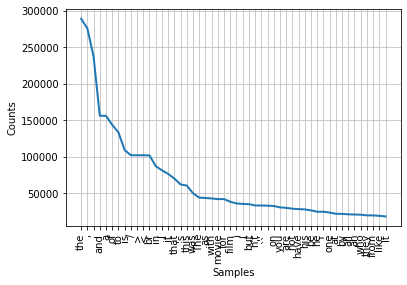


 ----- test -----
Number of words: 6894989, Vocab size: 132716, Vocab-Word ratio: 0.01924818154169644
Most Common Words: 
 [('the', 283618), (',', 267819), ('.', 231902), ('a', 152768), ('and', 152428), ('of', 141243), ('to', 130074), ('is', 105426), ('/', 100252), ('>', 100142)]


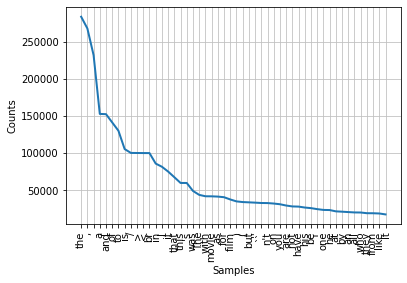

In [7]:
# using nltk @ train Vs test
for db, dbname in [ (train_x, "train"), (test_x, "test")]:
    print("\n ----- {} -----".format(dbname) )
    fd = nltk.FreqDist( nltk.word_tokenize(" ".join([ r for r in db]) )    )
    
#     tokenz = nltk.word_tokenize( db ) 
    vocab = set([w.lower for w in fd])
    
    print( "Number of words: {}, Vocab size: {}, Vocab-Word ratio: {}".format(
        fd.N(), len(vocab), len(vocab)/fd.N()
    ))
    
    print( "Most Common Words: \n", fd.most_common(10) ) 
    
    # plot top 50 words
    fd.plot(50)
    

In [8]:
# using nltk @ train entries

def word_stats( rec_txt ): 
    fd = nltk.FreqDist( nltk.word_tokenize( rec_txt ) )
    vocab = set([w.lower for w in fd])
    # word count, vocab count, vocab richness, n of most common word
    return ( fd.N(), len(vocab), len(vocab)/fd.N(), fd.freq( fd.max() )  )
            
    
stats_per_review = pd.Series(train_x).apply( word_stats)

print("Shapre of stats: {}".format( stats_per_review) )


Shapre of stats: 0        (71, 57, 0.8028169014084507, 0.04225352112676056)
1        (154, 100, 0.6493506493506493, 0.0454545454545...
2        (129, 89, 0.689922480620155, 0.05426356589147287)
3        (329, 150, 0.45592705167173253, 0.072948328267...
4        (398, 232, 0.5829145728643216, 0.0351758793969...
                               ...                        
24979    (222, 152, 0.6846846846846847, 0.0540540540540...
24980    (213, 136, 0.6384976525821596, 0.0281690140845...
24981    (372, 189, 0.5080645161290323, 0.0564516129032...
24982    (335, 189, 0.564179104477612, 0.04179104477611...
24983    (157, 104, 0.6624203821656051, 0.0382165605095...
Length: 24984, dtype: object


In [9]:
# summary stats per review 
mat = np.array(list(stats_per_review) )
df = pd.DataFrame( mat )
df.columns = [ 'n_words', 'n_vocab', 'lexical_diversity', 'n_most_common_1']
df.head(4)
print( "Summaries ")
df.describe()
    

Summaries 


,n_words,n_vocab,lexical_diversity,n_most_common_1
count,24984.000000,24984.000000,24984.000000,24984.000000
mean,282.198407,153.607949,0.598191,0.056772
std,210.334267,86.442229,0.094301,0.018129
min,11.000000,11.000000,0.040268,0.023256
25%,151.000000,97.000000,0.534247,0.046125
50%,210.000000,127.000000,0.597786,0.054106
75%,344.000000,187.000000,0.658333,0.064103
max,2818.000000,727.000000,1.000000,0.946309


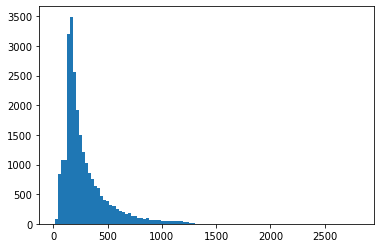

In [10]:
# distribution plots
plt.hist( df.n_words, bins=100 ); 

# B. Data Prep & Model Building

### Guide from Tensor Team

**How to Go About It** 
1. Calculate (n_observations / avg_words_per_observation ) t_ratio
2. If above t_ratio < 1500, tokenize as n-grams and use a simple multi-layer perceptron (MLP) model to classify

    a. tokenize into n-grams and vectorize 
    
    b. Score importance of the vectors and then select top 20K << tf-idf 
    
    c. build the multi-layer perceptron model
    
3. Else t_ratio > 1500, tokenize as words/sequences and use a sepCNN model to classify 

    a. tokenize into words and select top 20K words based on frequency 
    
    b. vectorize the word sequences
    
    c. If t_ratio < 15,000, then use a fine-tuned pre-trained embedding with the sepCNN model.
    
4. Measure model performance with different hyper params to find best model configuration


**So, above informs**
- what learning algorighm or model to use
- how to prepare the data for efficient learning 

The above is optimized for the best accuracy that could be achieved in the shortest compute time possible. Alternate approaches may fit better depending on what the goal is and data xtics


[Ref @TensorGuide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5)


In [11]:
t_ratio = len(df) / df.n_words.mean()
print("threshold ratio: {}\nFrom n = {}, avg_words  {}".format(t_ratio, len(df), df.n_words.mean() ) )

threshold ratio: 88.53345512233625
From n = 24984, avg_words  282.1984069804675


From above t_ratio, then we need n-grams bow approach with an MLP

**Model Types**
- Those that use word ordering I.E. sequence models like CNN, RNN
- Those that use bags/sets of words I.E. n-gram models like logit, simple MLP or fully connected NNs, gradient boosted trees and SVM


### 1. Vectorization for n-gram models

**Vectorization**
TF-IDF > Count Encoding > One-hot Encoding 
A sample is a vector 


**Feature Selection**
- may drop tokens extremly rare in the dataset
- Score feature importance and keep most relevant. Often case 20K features max suffice else may overfit. 

**Normalization**
Doesn't seem to add much value to text classification


### 2. Vectorization for sequence models
When word order is important

Samples are not individual words but a sequence of words 

**Tokenization**
word tokens out do character tokens. xter tokens may be used if texts have lots of typos, which is rare

**Vectorization**
Word embeddings > One-hot encoding 
A sample is n-D vector, where n = size(vocabulary) 

**Feature Selection**
Same as with n-gram based models 


### 3. Label vectorization
- Convert labels into numeric values like with an index 
- Internally, NNs will represent them using one-hot encoding to avoid inferring incorrect relations between them


[Ref @Tensor Guide](https://developers.google.com/machine-learning/guides/text-classification/step-3)

In [12]:
# for n-gram based vectorization 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# for sequence based vectorization
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# pickle vectorization models iff case e.g. with TF-IDF
import pickle 

In [13]:
## Data prep into n-grams
# 80% training split. Shuffle to clear inherent patterns in the db structure 
# How: 1. tokenize(n-grams, n>=1) 2. Vectorize(numerics) 3. Optimize vector rep

max_featurez = 20000
min_fq_for_relevance = 2


'''
n-gram based vectorization 

'''
ngramz = (1,2)
TOKEN_MODE = 'word' # word Vs character level 

def ngram_vectorizer(train_x, train_y, test_x):
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngramz,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': min_fq_for_relevance,
    }
    
    tmd = TfidfVectorizer( **kwargs)
    
    #learn vocab from training set and vectorize
    v_train_x = tmd.fit_transform( train_x) 
    v_test_x = tmd.transform( test_x)
        
    print( v_train_x[0] )
    
    # select top k features by f_classif and convert the vector to dense matrix b/c CountVectorizer produces sparse and tf and keras don't deal
    selector = SelectKBest( f_classif, k=min(max_featurez, v_train_x.shape[1] ) )
    selector.fit( v_train_x, train_y) 
    v_train_x = selector.transform( v_train_x).astype('float32').toarray().astype('float32')
    v_test_x = selector.transform( v_test_x).astype('float32').toarray().astype('float32')
    
    # pickle the tmd for reuse at predict b/c encode input in same way 
    with open('tfidf_trained_model.zmd', 'wb') as fd:
        pickle.dump(tmd, fd)
        
    with open('tfidf_trained_selector.zmd', 'wb') as fd:
        pickle.dump(selector, fd)
        
    return v_train_x, v_test_x


'''
sequence based vectorization using keras
'''
max_seq_len = 500 #limit seq len; extras are truncated 

def sequence_vectorizer(train_x, test_y):
    
    #create vocab from training text 
    tokenizer = text.Tokenizer(num_words=max_featurez) 
    tokenizer.fit_on_texts( train_x )
    
    #vectorize @ 
    v_train_x = tokenizer.texts_to_sequences( train_x )
    v_test_x = tokenizer.texts_to_sequences( test_x ) 
    
#     print(v_train_x[0])
    
    # select top k features by 
    #get max sequence length 
    max_l = min( len( max(x_train, key=len) ), max_seq_len )
    #fix sequences to max_seq_len by 1. pad shorter lengths and 2. truncate longer ones at the beginning
    v_train_x = sequence.pad_sequences(v_train_x, maxlen=max_l)
    v_test_x = sequence.pad_sequences(v_test_x, maxlen=max_l)
    
    return v_train_x, v_test_x, tokenizer.word_index


# C. Model Building

### 1. Constructing Last/Output Layer 
**Binary Classification**
- Single output b/c p(in A) = p( not in B)
- @tf.keras

    - activation function = sigmoid,  
    - loss function = binary cross-entropy, 
    
**Multi-Class Classification**
- n outputs where n is number of classes; one p(x) per class with sum 1
- @tf.keras

    - activation function = softmax,  
    - loss function = categorical cross-entropy, 
    
### 2. Constructing n-gram model
- recall: logits, gradient boosting machines, MLP, SVM
- MLP often does better; simple, good accuracy, little computation 


### 3. Constructing sequence model 
- recall: CNN, RNN,
- SepCNN found to do better and is data and compute efficient 
- First layer is usually the embedding layer, that learns relationship between words in a dense vector space
- Words are often not unique to a dataset (in same lang) so can borrow embeddings learnt from other datasets; i.e. pre-trained embeddings e.g. GloVe (Wikipedia data mainly, so may missout on conversation aspects of a chat or review for instance??)

    - **Fine tuned emebdding:** At first round, freeze to pretrained embedding weights and train rest of the layers. At subsequent round allow embedding layer to also learn. For large datasets may be just as good as training embeddings from scratch
    
- 
    
[Ref @TensorGuide](https://developers.google.com/machine-learning/guides/text-classification/step-4)

In [14]:
from tensorflow import keras

In [15]:
## 1. output layer define args  
def get_last_layer(n_classez):
    if n_classez == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = n_classez
    return units, activation

## 2. n-gram based MLP 
'''
- dropout layer for regularization to prevent overfitting 
'''
def ngram_mlp_model(n_hidden_layerz, hidden_unitz, dropout_ratez, input_shapez, n_classez):
    
    out_unitz, out_activation = get_last_layer(n_classez)
    
    md = keras.models.Sequential()
    
    md.add( keras.layers.Dropout(rate=dropout_ratez, input_shape=input_shapez) ) 
    
    for _ in range(n_hidden_layerz - 1):
        md.add( keras.layers.Dense(units=hidden_unitz, activation='relu') ) 
        md.add( keras.layers.Dropout(rate=dropout_ratez))
        
    md.add( keras.layers.Dense(units=out_unitz, activation=out_activation) ) 
    
    return( md )

## 3. sequence based model @ 
'''
A 4-layer SepCNN (depthwise separable CNN): https://arxiv.org/abs/1610.02357 
'''
def seq_sepCNN(
    blockz, # number of pairs of sepCNN and pooling blocks 
    filterz, # output dimension of the layers
    kernel_sizez, # len of the convolution window 
    embedding_dimz, # embedding vector dimension 
    dropout_ratez,  # for Dropout layer
    pool_sizez, # for MaxPooling layer 
    input_shapez, n_classez, n_featurez,
    use_pretrained_embeddz = False, 
    is_embedding_trainablez = False,
    embedding_matrixz = None # dict with embedding coefficients 
): 
    out_unitz, out_activation = get_last_layer(n_classez)
    
    md = keras.models.Sequential()
    
    #Embedding Layer: set if pre-trained and freeze or unfreeze as required 
    if use_pretrained_embeddz:
        md.add( keras.layers.Embedding(
            input_dim = n_featurez,
            output_dim = embedding_dimz,
            input_length = input_shapez[0], 
            weights = [embedding_matrixz],
            trainable = is_embedding_trainablez ))        
    else:
        md.add( keras.layers.Embedding(
            input_dim = n_featurez,
            output_dim = embedding_dimz,
            input_length = input_shapez[0] ))
        
    for _ in range( blockz - 1):
        md.add( keras.layers.Dropout( rate=dropout_ratez) )
        md.add( keras.layers.SeparableConv1D(
            filters = filterz, 
            kernel_size = kernel_sizez, 
            activation = 'relu', 
            bias_initializer = 'random_uniform', 
            depthwise_initializer = 'random_uniform', 
            padding = 'same' ))
        md.add(keras.layers.MaxPooling1D(pool_size=pool_sizez) ) 
    
    md.add( keras.layers.SeparableConv1D(
        filters = filterz * 2, 
        kernel_size = kernel_sizez, 
        activation = 'relu', 
        bias_initializer = 'random_uniform', 
        depthwise_initializer = 'random_uniform', 
        padding = 'same' ))
    
    md.add( keras.layers.SeparableConv1D(
        filters = filterz * 2, 
        kernel_size = kernel_sizez, 
        activation = 'relu', 
        bias_initializer = 'random_uniform', 
        depthwise_initializer = 'random_uniform', 
        padding = 'same' ))
    
    md.add( keras.layers.GlobalAveragePooling1D( ) )
    
    md.add( keras.layers.Dropout(rate=dropout_ratez) )
    
    md.add( keras.layers.Dense(out_unitz, activation=out_activation) )
    
    return md

In [16]:
# ngram_mlp_model(4, 10, 0.1, [14, 3], 3).summary()

# seq_sepCNN( 2, 11, 3, 7, 0.1, 4, [14, 3], 3, 13).summary()


# D. Training the Model
predict using current model state --> assess goodness --> update model weights and params --> repeat to convergence 

Three key params
1. **Metric:** how to assess goodness. E.G. accuracy= n(correct)/n(all samples) 
2. **Loss Function:** loss to be minimize while tuning weights. E.G. cross-entropy, which works well for classification problems 
3. **Optimizer:** how weights are updated using loss function output. E.G. adam, which is popular 

**Training hyper params**
General 
- Number of layers: Represents complexity of how much to be learnt and so over/underfitting. For text classification: 2 hidden layers for MLP and 4 for sepCNN

- Number of units per layer: Try to minimize information loss between layers. 32 or 64 units seem to do 

- Dropout rate: Dropout layers are for regularization to avoid overfitting. 0.2 to 0.5 should do

- Learning rate: rate at which weights change; large rate = large swings. Start at 1e-4 and increase if training is too slow. Check out decreasing rate learning rate too.  

SepCNN specific 
- Kernel size: convolution window size. Go for 3 or 5. 

- Embedding dimension: recommended = 50 - 300. 


In [17]:
### Add learning params to keras models using model.compile 
### Training keras models using model.fit 

def train_ngram_model(
    train_test_data, 
    learning_rate=1e-3, epochs=10, batch_size=128, layerz=2, unitz=64, dropout=0.2 ):
    
    # 1. fetch data 
    (train_x, train_y), (test_x, test_y) = train_test_data
    
    #TODO: verify n_classes are similar between test and train 
    num_classez = len( pd.Series(train_y).unique() )
    
    # 2. vectorize texts 
    v_train_x, v_test_x = ngram_vectorizer( train_x, train_y, test_x)
    
    # 3. create model 
    model = ngram_mlp_model(
        n_hidden_layerz=layerz,
        hidden_unitz=unitz,
        dropout_ratez=dropout,
        input_shapez=v_train_x.shape[1:], 
        n_classez=num_classez)
    
    # 4. complie @ metric accuracy, optimizer adam and loss binary Vs multi-class 
    loss = 'binary_crossentropy' if num_classez == 2 else 'sparse_categorical_crossentropy'
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile( optimizer=optimizer, loss=loss, metrics=['acc'] ) 
    
    # 5. create callback for early stopping on validation loss if not loss decrease in two consecutive tries
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    ]
    
    # 6. train and validate 
    train_history = model.fit(
        v_train_x,
        train_y, 
        epochs = epochs,
        callbacks=callbacks,
        validation_data=(v_test_x, test_y), 
        verbose=1, # log once per epoch = 2       
#         batch_size=batch_size
    )
    
    #7. save model
    model.save( 'IMDB_ngram_mlp_model.h5') 
    
    train_history = train_history.history
    
    return train_history['val_acc'][-1], train_history['val_loss'][-1]

In [18]:
a, l = train_ngram_model( ((train_x, train_y), (test_x, test_y)) )

print( "COMPLETED @ Accuracy: {} Loss: {}".format(a, l))

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


  (0, 436264)	0.14184279221351037
  (0, 435788)	0.030428523609670303
  (0, 434358)	0.10401265231633247
  (0, 434219)	0.07109304780418932
  (0, 429023)	0.10414843465774476
  (0, 428476)	0.180259074830679
  (0, 426469)	0.05147421092664268
  (0, 424259)	0.14903091595010673
  (0, 424220)	0.12153850464166552
  (0, 424156)	0.10838936392513034
  (0, 407351)	0.123326770921155
  (0, 406810)	0.03900035446611739
  (0, 396004)	0.16216020175021273
  (0, 395990)	0.10257996203620415
  (0, 389718)	0.08588777846923827
  (0, 387689)	0.020134471980400307
  (0, 382617)	0.04239052065225393
  (0, 381613)	0.02082177680659653
  (0, 380093)	0.11186267273101246
  (0, 379641)	0.03476361564080383
  (0, 378932)	0.11125810368250727
  (0, 378674)	0.034802107638283855
  (0, 374092)	0.11509220449558201
  (0, 373838)	0.09444536829881364
  (0, 373235)	0.07424433687286579
  :	:
  (0, 166496)	0.1594496491762602
  (0, 165467)	0.02968022225233819
  (0, 115817)	0.06867263676204087
  (0, 108559)	0.17680562094122604
  (0, 1084

# E. Use it

In [19]:
import tensorflow as tf

In [20]:
# A. Load saved model and TF-IDF vectorizer 

# 1. load model
trained_model = keras.models.load_model( 'IMDB_ngram_mlp_model.h5')
print("Loaded Model: {}\n========\n".format(trained_model.summary() ) )

# 2. load vectorizer
with open('tfidf_trained_model.zmd', 'rb') as fd:
    tfidf = pickle.load(fd)    
print("Loaded TF-IDF Vectorizer: {}\n========\n".format(tfidf) )

# 3. Load features selector 
with open('tfidf_trained_selector.zmd', 'rb') as fd:
    fselector = pickle.load(fd)    
print("Loaded Selector: {}\n========\n".format(fselector) )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
Loaded Model: None

Loaded TF-IDF Vectorizer: TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
                dtype='int32', encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None

In [21]:
# B. Do some prediction 
sample_reviews = [ "That was such a good movie!", "That was terribly good!", 
                  "That was such a bad movie!", "Amazing! How can something so bad be out there!"]

for s in sample_reviews:
#     # 1. prep input string same as training strings : TODO save vectorizer to file as well so don't have to recreate it each time 
#     _, v_input_x = ngram_vectorizer(train_x, train_y, [s])

    # 1. use saved tfidf vectorizer & k-best selector: vectorize, select top k and make dense
    v_input_x = tfidf.transform(  [s] )
    v_input_x = fselector.transform( v_input_x).astype('float32').toarray().astype('float32')
   
    # 2. run prediction 
    lbl = trained_model.predict( v_input_x )
    # 3. And we have .....
    print("\nPREDICTION RESULTS: {} ==> {}".format(s, lbl) )


PREDICTION RESULTS: That was such a good movie! ==> [[0.4416152]]

PREDICTION RESULTS: That was terribly good! ==> [[0.08398636]]

PREDICTION RESULTS: That was such a bad movie! ==> [[0.00255422]]

PREDICTION RESULTS: Amazing! How can something so bad be out there! ==> [[0.44646907]]


In [22]:
import keras as keras_pyi
from tensorflow import  keras as keras_tf

print("PYI version: ", keras_pyi.__version__)
print("TF version: ", keras_tf.__version__)

PYI version:  2.3.1
TF version:  2.2.4-tf


Using TensorFlow backend.
